# **Pet Adoption Simple (Part II)**

This Kernel **continues my previous** "[Pet Adoption Simple](https://www.kaggle.com/ludovicoristori/pets-adoption-simple-pandas-random-forest)". Actually, when I started loading and processing the json data, that notebook became all but simple. So I took this decision: one new kernel (this) to use the data prepared and to add some modification to the basic dataframe df_all, too. 

Topics of this notebook: focus on **categorical data** and **merging different dataframes** (images, SVD of descriptions). In addition, I substituted Random Forests and XGBM with **LGBM** which I found better with columns like description or breed (categorical with many values).

Thanks to [Abishek](http://https://www.kaggle.com/abhishek/maybe-something-interesting-here) for the idea of rescaling/rounding outputs. It's the first time I have seen something like that and started using it practically anytime. Probably I abused a bit in the final part of this notebook, let's see after the submission...

# Imports and Data Preparation

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [59]:
import scipy as sp
from collections import Counter
from functools import partial

In [60]:
import os
print(os.listdir("../input"))

['pets-adoption-simple-pandas-random-forest', 'petfinder-adoption-prediction', 'pet-adoption-only-text-svd', 'pet-adoption-only-images']


In [61]:
data_path="../input/petfinder-adoption-prediction"
first_kernel_path="../input/pets-adoption-simple-pandas-random-forest"
image_kernel_path="../input/pet-adoption-only-images"
svd_kernel_path="../input/pet-adoption-only-text-svd"

In [62]:
train = pd.read_csv(data_path+"/train/train.csv")
test = pd.read_csv(data_path+"/test/test.csv")
color_labels = pd.read_csv(data_path+"/color_labels.csv")
breed_labels = pd.read_csv(data_path+"/breed_labels.csv")
state_labels = pd.read_csv(data_path+"/state_labels.csv")

In [63]:
import warnings
warnings.filterwarnings('ignore')

In [64]:
def print_columns_with_null(df):
    dfn=df.isnull().sum()
    return dfn[dfn>0]

From "Pet Adoption Simple" we have:

* df_all0, basic dataframe
* df_svd, SVD of descriptions in df_all0 and img_data 
* txt_data, data from sentiment analysis
* img_data, data from images

The preparation basically consists of merging the information in one dataframe, the "new" df_all


In [65]:
df_all0 = pd.read_csv(first_kernel_path+"/df_all0.csv")
df_all0.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,SimpleName,DescriptionLength,DescrLengthCat,SimpleRescuerID,SimpleBreed2,SimpleBreed1
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,Other Names,359,750,Other Rescuers,0,299
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,Other Names,118,250,Other Rescuers,0,265
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,Other Names,393,750,fa90fa5b1ee11c86938398b60abc32cb,0,307
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,Other Names,146,250,Other Rescuers,0,307
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,Other Names,390,750,95481e953f8aed9ec3d16fc4509537e8,0,307


In [66]:
txt_data = pd.read_csv(first_kernel_path+"/txt_data.csv")
txt_data.columns = ['PetID','sent_magnitude','sent_score','sent_language']
txt_data.head()

,PetID,sent_magnitude,sent_score,sent_language
0,b3b6d78f5,1.2,-0.1,en
1,4b31d7b1e,0.9,0.9,en
2,20bad295b,1.3,0.6,en
3,d81afce4f,0.7,0.1,en
4,dc8359e75,1.7,0.2,en


In [67]:
img_df1a = pd.read_csv(image_kernel_path+"/img_df1a_local.csv")
img_df1a.columns = ['PetID','ImageID','img_met_score','img_met_description']
img_df1a.head()

,PetID,ImageID,img_met_score,img_met_description
0,d0956e39e,7,0.990992,dog
1,d0956e39e,7,0.969505,dog like mammal
2,d0956e39e,7,0.941309,dog breed
3,d0956e39e,7,0.923620,mammal
4,d0956e39e,7,0.836046,puppy


In [68]:
img_df1c = pd.read_csv(image_kernel_path+"/img_df1c_local.csv")
img_df1c.columns = ['PetID','ImageID','img_crp_x','img_crp_y','img_crp_conf','img_crp_if']
img_df1c.head()

,PetID,ImageID,img_crp_x,img_crp_y,img_crp_conf,img_crp_if
0,d0956e39e,7,129,75,0.8,1.00
1,2275c7ba3,1,399,299,0.8,1.00
2,251f4dd60,1,359,479,0.8,1.00
3,0e6f26f19,2,278,399,0.8,0.95
4,f3abe5d8c,3,215,287,0.8,1.00


In [69]:
img_df1p = pd.read_csv(image_kernel_path+"/img_df1p_local.csv")
img_df1p.columns = ['PetID','ImageID','img_par_red','img_par_green','img_par_blue','img_par_score','img_par_pf']
img_df1p.head()

,PetID,ImageID,img_par_red,img_par_green,img_par_blue,img_par_score,img_par_pf
0,d0956e39e,7,25,25,25,0.227257,0.065105
1,d0956e39e,7,142,155,154,0.037983,0.180386
2,d0956e39e,7,48,49,46,0.159047,0.127307
3,d0956e39e,7,47,50,30,0.142071,0.030272
4,d0956e39e,7,82,85,63,0.091473,0.032138


In [70]:
des_svd_df = pd.read_csv(svd_kernel_path+"/des_svd_df.csv")
des_svd_df.iloc[:,0:10].head()

,PetID,Description,AdoptionSpeed,des_svd0,des_svd1,des_svd2,des_svd3,des_svd4,des_svd5,des_svd6
0,86e1089a3,Nibble is a 3+ month old ball of cuteness. He ...,2,0.176157,-0.058593,-0.055123,-0.013193,-0.020942,0.010318,0.033072
1,6296e909a,I just found it alone yesterday near my apartm...,0,0.128097,-0.049430,0.015260,0.024499,-0.093690,0.001221,0.012304
2,3422e4906,Their pregnant mother was dumped by her irresp...,3,0.157601,-0.049278,0.160950,-0.066263,0.036256,-0.135540,-0.031962
3,5842f1ff5,"Good guard dog, very alert, active, obedience ...",2,0.137033,-0.035897,0.062354,0.157901,0.093029,-0.031316,-0.062379
4,850a43f90,This handsome yet cute boy is up for adoption....,2,0.236096,0.011709,0.036112,-0.012568,0.029042,0.098451,0.115440


In [71]:
prev_subm = pd.read_csv("../input/pets-adoption-simple-pandas-random-forest/submission.csv")
prev_subm.head()

,PetID,AdoptionSpeed
0,378fcc4fc,2
1,73c10e136,4
2,72000c4c5,4
3,e147a4b9f,3
4,43fbba852,4


# Merging dataframes

In [72]:
df_all0.shape

(18941, 30)

In [73]:
txt_data.shape

(18257, 4)

In [74]:
img_df1a.shape

(546164, 4)

In [75]:
img_df1c.shape

(58297, 6)

In [76]:
img_df1p.shape

(579150, 7)

In [77]:
des_svd_df.shape

(18941, 243)

What can we do with RescuerID, as there are so many? In the previous kernel I distincted top rescuers from others. This time I try to count the occurrences of every rescuer, and then find a sort of rescuer level or rank to include in the main dataframe.

In [78]:
rescuers=df_all0.groupby(by='RescuerID')['RescuerID'].count()
df_rescuers=pd.DataFrame(rescuers)
df_rescuers.columns=['ResLev']
df_rescuers.reset_index(inplace=True)
df_rescuers.head()

,RescuerID,ResLev
0,0007e457eb0583479bb888d54764911f,1
1,0008ef529da74e9701db7eaaa4d9115a,2
2,000a5830787b64da2d61b0bbceb7676d,4
3,000acff3d6148772579b3e623988131b,1
4,001b9870d4db6d26e2b52520dfbce249,1


In [79]:
dfm=df_all0.merge(df_rescuers,on='RescuerID')
numeric_cols=['Age','PhotoAmt','Quantity','Fee','DescriptionLength','ResLev']
categorical_cols=['Sterilized','FurLength','Breed1','State','AdoptionSpeed','Breed2','MaturitySize','Gender','Dewormed','Color1','Color2','Color3','Health']
cols=['PetID']+numeric_cols+categorical_cols
dfm=dfm[cols]
dfm.shape

(18941, 20)

In [80]:
dfm=dfm.merge(txt_data,on='PetID', how='left')
categorical_cols=categorical_cols+['sent_language']
dfm.shape

(18941, 23)

In [81]:
n_svd=32
svd=des_svd_df.iloc[:,0:n_svd+3]
svd.drop('Description',axis=1,inplace=True)
svd.drop('AdoptionSpeed',axis=1,inplace=True)
dfm=dfm.merge(svd,on='PetID', how='left')
dfm.shape

(18941, 55)

In [82]:
img_df1ad=img_df1a.groupby(['PetID'])['img_met_description'].apply(', '.join).reset_index()

In [83]:
img_df1ad['img_met_description1']=img_df1ad['img_met_description'].apply(lambda s:s.split(',')).apply(set).apply(','.join)

In [84]:
img_df1ad['img_met_description1'].loc[0]

' turkish van, cat like mammal, khao manee, paw, snout, whiskers, nose, eye,cat, cat, burmilla, small to medium sized cats, kitten, european shorthair, domestic short haired cat, fur, aegean cat'

In [85]:
img_df1ad['img_met_description'].loc[0]

'cat, small to medium sized cats, whiskers, cat like mammal, nose, eye, domestic short haired cat, snout, khao manee, kitten, cat, small to medium sized cats, cat like mammal, whiskers, domestic short haired cat, kitten, fur, european shorthair, aegean cat, snout, cat, small to medium sized cats, cat like mammal, whiskers, kitten, domestic short haired cat, turkish van, fur, cat, small to medium sized cats, cat like mammal, whiskers, kitten, domestic short haired cat, paw, aegean cat, fur, turkish van, cat, small to medium sized cats, whiskers, cat like mammal, eye, khao manee, domestic short haired cat, kitten, burmilla, snout, cat, small to medium sized cats, cat like mammal, whiskers, domestic short haired cat, kitten, aegean cat, european shorthair, fur, turkish van'

In [86]:
img_df1ad.drop('img_met_description',axis=1,inplace=True)
img_df1ad.head()

,PetID,img_met_description1
0,0008c5398,"turkish van, cat like mammal, khao manee, paw..."
1,000a290e4,"sporting group, st bernard, moscow watchdog, ..."
2,000fb9572,"snout, vulnerable native breeds, mammal, patt..."
3,0011d7c25,"kitten, cat like mammal, snowshoe, snout, whi..."
4,00156db4a,"snout, plummer terrier, street dog, grass, fe..."


In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [88]:
def find_svd(df,txt_col_name,n_comp):
    tfv = TfidfVectorizer(analyzer='word', stop_words = 'english', token_pattern=r'\b[a-zA-Z]\w+\b',
                      min_df=1,  max_features=10000, strip_accents='unicode', 
                      ngram_range=(1, 32), use_idf=1, smooth_idf=1, sublinear_tf=1,)
    corpus=list(df[txt_col_name])
    txt_trasf=tfv.fit_transform(corpus)
    svd = TruncatedSVD(n_components=n_comp, n_iter=10, tol=1.0)
    svd.fit(txt_trasf)
    txt_svd=svd.transform(txt_trasf)
    txt_svd_df=pd.DataFrame(txt_svd)
    return(txt_svd_df)

In [89]:
nc=16
img_met_svd=find_svd(img_df1ad,'img_met_description1',nc)
img_met_svd.columns=['SVD_'+str(c) for c in range(0,nc)]
img_met_svd['PetID']=img_df1ad['PetID']

In [90]:
img_df1ar=img_met_svd
img_df1ar['img_met_score_max']=img_df1a.groupby(by=['PetID','ImageID'],as_index=False).agg({'img_met_score': 'max'})['img_met_score'] 
img_df1ar['img_met_score_min']=img_df1a.groupby(by=['PetID','ImageID'],as_index=False).agg({'img_met_score': 'min'})['img_met_score'] 
img_df1ar.head()

,SVD_0,SVD_1,SVD_2,SVD_3,SVD_4,SVD_5,SVD_6,SVD_7,SVD_8,SVD_9,SVD_10,SVD_11,SVD_12,SVD_13,SVD_14,SVD_15,PetID,img_met_score_max,img_met_score_min
0,0.398203,-0.138619,-0.116221,0.019961,-0.000298,0.019015,0.034636,0.016716,-0.037962,0.111480,-0.282531,-0.059173,0.016647,-0.093331,0.024212,-0.288969,0008c5398,0.994370,0.731031
1,0.106687,0.280119,0.015113,-0.091815,-0.091824,-0.036223,-0.009868,-0.050827,-0.041602,0.013966,-0.012977,0.014960,-0.012639,-0.032436,-0.093635,0.008198,000a290e4,0.993564,0.545785
2,0.084493,0.194215,0.030726,-0.095549,-0.079487,-0.118602,0.035977,0.014190,0.014766,-0.008878,-0.011679,0.122016,-0.008186,0.111590,0.125961,-0.045579,000fb9572,0.990945,0.541273
3,0.238585,-0.012836,0.077836,-0.057196,-0.004064,-0.006867,-0.000357,-0.049938,0.041704,-0.086468,-0.008234,0.004355,-0.010657,0.081234,-0.086184,0.184448,0011d7c25,0.993178,0.599378
4,0.105610,0.287092,0.000107,-0.054977,0.004601,-0.187249,0.002623,-0.103585,-0.108216,0.030666,0.015354,-0.072204,-0.009317,-0.040304,-0.048816,-0.013220,00156db4a,0.993516,0.566551


In [91]:
img_df1cr1=img_df1c[img_df1c['ImageID']==1]
img_df1cr1.drop('ImageID', axis=1, inplace=True)
img_df1cr1.columns=['PetID','img_crp_x1','img_crp_y1','img_crp_conf1','img_crp_if1']
img_df1cr2=img_df1c[img_df1c['ImageID']==2]
img_df1cr2.drop('ImageID', axis=1, inplace=True)
img_df1cr2.columns=['PetID','img_crp_x2','img_crp_y2','img_crp_conf2','img_crp_if2']
img_df1cr3=img_df1c[img_df1c['ImageID']==3]
img_df1cr3.drop('ImageID', axis=1, inplace=True)
img_df1cr3.columns=['PetID','img_crp_x3','img_crp_y3','img_crp_conf3','img_crp_if3']
img_df1cr=img_df1cr1
img_df1cr.head()

,PetID,img_crp_x1,img_crp_y1,img_crp_conf1,img_crp_if1
1,2275c7ba3,399,299,0.8,1.0
2,251f4dd60,359,479,0.8,1.0
9,9f41a024f,399,299,0.8,1.0
10,2eaab0cb1,269,478,0.8,1.0
11,9926c6e5b,299,399,0.8,1.0


In [92]:
img_df1cr=img_df1cr.merge(img_df1cr2,on='PetID')
img_df1cr=img_df1cr.merge(img_df1cr3,on='PetID')
img_df1cr.head()

,PetID,img_crp_x1,img_crp_y1,img_crp_conf1,img_crp_if1,img_crp_x2,img_crp_y2,img_crp_conf2,img_crp_if2,img_crp_x3,img_crp_y3,img_crp_conf3,img_crp_if3
0,2275c7ba3,399,299,0.8,1.0,399,299,0.8,1.00,399,299,0.8,1.0
1,251f4dd60,359,479,0.8,1.0,359,479,0.8,1.00,359,479,0.8,1.0
2,2eaab0cb1,269,478,0.8,1.0,359,479,1.0,1.27,269,478,0.8,1.0
3,fa07f7477,126,224,0.8,1.0,126,224,0.8,1.00,399,299,0.8,1.0
4,36c4871dc,359,479,0.8,1.0,359,479,0.8,1.00,359,479,0.8,1.0


In [93]:
img_df1cr.isna().sum()

PetID            0
img_crp_x1       0
img_crp_y1       0
img_crp_conf1    0
img_crp_if1      0
img_crp_x2       0
img_crp_y2       0
img_crp_conf2    0
img_crp_if2      0
img_crp_x3       0
img_crp_y3       0
img_crp_conf3    0
img_crp_if3      0
dtype: int64

In [94]:
img_df1cr.fillna(-1, inplace=True)

In [95]:
img_df1p.head()

,PetID,ImageID,img_par_red,img_par_green,img_par_blue,img_par_score,img_par_pf
0,d0956e39e,7,25,25,25,0.227257,0.065105
1,d0956e39e,7,142,155,154,0.037983,0.180386
2,d0956e39e,7,48,49,46,0.159047,0.127307
3,d0956e39e,7,47,50,30,0.142071,0.030272
4,d0956e39e,7,82,85,63,0.091473,0.032138


In [96]:
img_df1p.shape

(579150, 7)

In [97]:
img_df1pg=img_df1p.groupby(by=['PetID','ImageID'],as_index=False).agg({'img_par_score': 'max', 
                                                             'img_par_red':'first',
                                                             'img_par_green':'first',
                                                             'img_par_blue':'first',
                                                             'img_par_pf':'first'})
img_df1pg.head()

,PetID,ImageID,img_par_score,img_par_red,img_par_green,img_par_blue,img_par_pf
0,0008c5398,1,0.156626,203,196,192,0.140030
1,0008c5398,2,0.201247,167,159,149,0.123552
2,0008c5398,3,0.481379,220,41,122,0.152586
3,0008c5398,4,0.182417,118,73,55,0.050089
4,0008c5398,5,0.237771,235,233,225,0.174146


In [98]:
img_df1pr1=img_df1pg[img_df1pg['ImageID']==1]
img_df1pr1.drop('ImageID', axis=1, inplace=True)
img_df1pr1.columns=['PetID','img_par_red1','img_par_green1','img_par_blue1','img_par_pf1','img_par_score1']
img_df1pr2=img_df1pg[img_df1pg['ImageID']==2]
img_df1pr2.drop('ImageID', axis=1, inplace=True)
img_df1pr2.columns=['PetID','img_par_red2','img_par_green2','img_par_blue2','img_par_pf2','img_par_score2']
img_df1pr3=img_df1pg[img_df1pg['ImageID']==3]
img_df1pr3.drop('ImageID', axis=1, inplace=True)
img_df1pr3.columns=['PetID','img_par_red3','img_par_green3','img_par_blue3','img_par_pf3','img_par_score3']
img_df1pr=img_df1pr1
img_df1pr.head()

,PetID,img_par_red1,img_par_green1,img_par_blue1,img_par_pf1,img_par_score1
0,0008c5398,0.156626,203,196,192,0.140030
6,000a290e4,0.138713,155,112,91,0.015744
8,000fb9572,0.176119,23,19,16,0.243393
13,0011d7c25,0.228336,157,147,125,0.267256
16,00156db4a,0.243056,175,155,126,0.189856


In [99]:
img_df1pr=img_df1pr.merge(img_df1pr2,on='PetID')
img_df1pr=img_df1pr.merge(img_df1pr3,on='PetID')
img_df1pr.head()

,PetID,img_par_red1,img_par_green1,img_par_blue1,img_par_pf1,img_par_score1,img_par_red2,img_par_green2,img_par_blue2,img_par_pf2,img_par_score2,img_par_red3,img_par_green3,img_par_blue3,img_par_pf3,img_par_score3
0,0008c5398,0.156626,203,196,192,0.140030,0.201247,167,159,149,0.123552,0.481379,220,41,122,0.152586
1,0011d7c25,0.228336,157,147,125,0.267256,0.146296,226,234,243,0.087582,0.472070,176,155,135,0.060614
2,00156db4a,0.243056,175,155,126,0.189856,0.172790,184,197,132,0.030898,0.147040,150,160,101,0.100272
3,001a1aaad,0.323089,235,230,231,0.047835,0.181447,162,117,64,0.020622,0.219037,157,108,70,0.021258
4,001b1507c,0.180354,164,148,141,0.160597,0.241372,165,150,136,0.076830,0.260583,96,83,78,0.127645


Ok, it's time to merge all the images tables:

In [100]:
img=img_df1ar
img=img.merge(img_df1cr,on=['PetID'], how='left')
img=img.merge(img_df1pr,on=['PetID'], how='left')
img.shape

(14652, 46)

In [101]:
img.fillna(-1,inplace=True)
img.head()

,SVD_0,SVD_1,SVD_2,SVD_3,SVD_4,SVD_5,SVD_6,SVD_7,SVD_8,SVD_9,SVD_10,SVD_11,SVD_12,SVD_13,SVD_14,SVD_15,PetID,img_met_score_max,img_met_score_min,img_crp_x1,img_crp_y1,img_crp_conf1,img_crp_if1,img_crp_x2,img_crp_y2,img_crp_conf2,img_crp_if2,img_crp_x3,img_crp_y3,img_crp_conf3,img_crp_if3,img_par_red1,img_par_green1,img_par_blue1,img_par_pf1,img_par_score1,img_par_red2,img_par_green2,img_par_blue2,img_par_pf2,img_par_score2,img_par_red3,img_par_green3,img_par_blue3,img_par_pf3,img_par_score3
0,0.398203,-0.138619,-0.116221,0.019961,-0.000298,0.019015,0.034636,0.016716,-0.037962,0.111480,-0.282531,-0.059173,0.016647,-0.093331,0.024212,-0.288969,0008c5398,0.994370,0.731031,348.0,478.0,0.8,1.0,359.0,479.0,0.8,1.0,292.0,478.0,0.8,1.0,0.156626,203.0,196.0,192.0,0.140030,0.201247,167.0,159.0,149.0,0.123552,0.481379,220.0,41.0,122.0,0.152586
1,0.106687,0.280119,0.015113,-0.091815,-0.091824,-0.036223,-0.009868,-0.050827,-0.041602,0.013966,-0.012977,0.014960,-0.012639,-0.032436,-0.093635,0.008198,000a290e4,0.993564,0.545785,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000
2,0.084493,0.194215,0.030726,-0.095549,-0.079487,-0.118602,0.035977,0.014190,0.014766,-0.008878,-0.011679,0.122016,-0.008186,0.111590,0.125961,-0.045579,000fb9572,0.990945,0.541273,399.0,267.0,0.8,1.0,399.0,267.0,0.8,1.0,399.0,299.0,0.8,1.0,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000
3,0.238585,-0.012836,0.077836,-0.057196,-0.004064,-0.006867,-0.000357,-0.049938,0.041704,-0.086468,-0.008234,0.004355,-0.010657,0.081234,-0.086184,0.184448,0011d7c25,0.993178,0.599378,298.0,399.0,0.8,1.0,298.0,399.0,0.8,1.0,399.0,299.0,0.8,1.0,0.228336,157.0,147.0,125.0,0.267256,0.146296,226.0,234.0,243.0,0.087582,0.472070,176.0,155.0,135.0,0.060614
4,0.105610,0.287092,0.000107,-0.054977,0.004601,-0.187249,0.002623,-0.103585,-0.108216,0.030666,0.015354,-0.072204,-0.009317,-0.040304,-0.048816,-0.013220,00156db4a,0.993516,0.566551,399.0,266.0,0.8,1.0,266.0,399.0,0.8,1.0,266.0,399.0,0.8,1.0,0.243056,175.0,155.0,126.0,0.189856,0.172790,184.0,197.0,132.0,0.030898,0.147040,150.0,160.0,101.0,0.100272


In [102]:
dfm=dfm.merge(img,on='PetID', how='left')
dfm.shape

(18941, 100)

In [103]:
df_all=dfm
df_all.head()

,PetID,Age,PhotoAmt,Quantity,Fee,DescriptionLength,ResLev,Sterilized,FurLength,Breed1,State,AdoptionSpeed,Breed2,MaturitySize,Gender,Dewormed,Color1,Color2,Color3,Health,sent_magnitude,sent_score,sent_language,des_svd0,des_svd1,des_svd2,des_svd3,des_svd4,des_svd5,des_svd6,des_svd7,des_svd8,des_svd9,des_svd10,des_svd11,des_svd12,des_svd13,des_svd14,des_svd15,des_svd16,...,SVD_5,SVD_6,SVD_7,SVD_8,SVD_9,SVD_10,SVD_11,SVD_12,SVD_13,SVD_14,SVD_15,img_met_score_max,img_met_score_min,img_crp_x1,img_crp_y1,img_crp_conf1,img_crp_if1,img_crp_x2,img_crp_y2,img_crp_conf2,img_crp_if2,img_crp_x3,img_crp_y3,img_crp_conf3,img_crp_if3,img_par_red1,img_par_green1,img_par_blue1,img_par_pf1,img_par_score1,img_par_red2,img_par_green2,img_par_blue2,img_par_pf2,img_par_score2,img_par_red3,img_par_green3,img_par_blue3,img_par_pf3,img_par_score3
0,86e1089a3,3,1.0,1,100,359,8,2,1,299,41326,2,0,1,1,2,1,7,0,1,2.4,0.3,en,0.176157,-0.058593,-0.055123,-0.013193,-0.020942,0.010318,0.033072,-0.017084,-0.054543,0.014061,-0.017831,-0.043603,-0.015223,0.000065,-0.005528,0.021210,-0.033693,...,-0.100845,-0.106545,0.062080,-0.020093,0.042930,-0.035867,-0.003806,-0.000037,-0.010626,0.003108,0.067710,0.973180,0.594713,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.00000,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000
1,4e3a1f99b,12,1.0,1,0,158,8,2,1,303,41326,2,0,2,2,2,1,2,4,1,1.2,0.6,en,0.097398,-0.034781,0.000789,-0.018752,0.042516,0.016205,0.018925,0.009870,0.122586,0.014681,-0.025527,-0.029492,0.024919,-0.070489,0.017895,0.023975,-0.052588,...,-0.011231,-0.024976,0.050455,-0.031193,0.084801,-0.146127,-0.024284,0.001071,-0.017968,0.016358,0.039899,0.973593,0.588032,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.00000,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000
2,369197890,3,1.0,1,100,372,8,2,3,276,41326,2,303,2,2,2,1,2,4,1,1.6,0.0,en,0.158562,-0.052908,-0.050412,-0.011370,-0.017128,0.010056,0.028914,-0.015742,-0.050120,0.012985,-0.017008,-0.041975,-0.014281,-0.002461,-0.005637,0.020056,-0.029206,...,-0.000351,-0.013101,0.051003,-0.040450,0.115578,-0.156119,-0.018513,0.005051,-0.011221,0.018634,-0.009473,0.940876,0.514434,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.00000,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000
3,5b4e331cf,4,2.0,2,0,539,8,2,1,266,41326,3,0,2,2,2,1,0,0,1,2.8,0.3,en,0.163135,-0.055853,-0.060846,-0.005602,-0.039837,0.004194,-0.001735,-0.032782,-0.032017,0.017014,-0.035282,-0.077312,-0.006129,-0.039305,-0.030743,0.053367,-0.023716,...,-0.097073,-0.091336,0.057207,-0.023219,0.063891,-0.030386,0.001714,-0.001932,-0.001122,0.003625,0.093020,0.977256,0.617599,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.00000,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000
4,e73146163,7,4.0,1,0,1173,8,2,2,288,41326,2,299,1,2,3,2,7,0,1,5.6,0.1,en,0.216624,-0.077011,-0.085536,-0.021723,-0.082778,-0.025563,-0.106701,-0.077391,0.063329,0.063161,0.002243,-0.003744,-0.016285,0.017101,0.008358,0.049606,0.002073,...,0.021897,-0.066152,0.039172,0.014600,-0.107743,-0.063172,-0.038657,0.001788,-0.045134,0.014042,-0.001334,0.983586,0.550084,399.0,265.0,0.8,1.0,265.0,399.0,0.8,1.0,399.0,265.0,0.8,1.0,0.221571,157.0,158.0,146.0,0.04229,0.603197,156.0,158.0,149.0,0.136703,0.402199,124.0,123.0,112.0,0.027931


In [104]:
print_columns_with_null(df_all)

sent_magnitude        684
sent_score            684
sent_language         684
SVD_0                4289
SVD_1                4289
SVD_2                4289
SVD_3                4289
SVD_4                4289
SVD_5                4289
SVD_6                4289
SVD_7                4289
SVD_8                4289
SVD_9                4289
SVD_10               4289
SVD_11               4289
SVD_12               4289
SVD_13               4289
SVD_14               4289
SVD_15               4289
img_met_score_max    4289
img_met_score_min    4289
img_crp_x1           4289
img_crp_y1           4289
img_crp_conf1        4289
img_crp_if1          4289
img_crp_x2           4289
img_crp_y2           4289
img_crp_conf2        4289
img_crp_if2          4289
img_crp_x3           4289
img_crp_y3           4289
img_crp_conf3        4289
img_crp_if3          4289
img_par_red1         4289
img_par_green1       4289
img_par_blue1        4289
img_par_pf1          4289
img_par_score1       4289
img_par_red2

In [105]:
df_all['sent_magnitude'].fillna(-1, inplace=True) # -1=no comments received
df_all['sent_score'].fillna(-1, inplace=True) # -1=no comments received
df_all['sent_language'].fillna('en', inplace=True) # default=english

In [106]:
df_all.fillna(-1, inplace=True) # -1=no images

In [107]:
print_columns_with_null(df_all)

Series([], dtype: int64)

In [108]:
# categorical_cols=categorical_cols # no add to do
categorical_cols

['Sterilized',
 'FurLength',
 'Breed1',
 'State',
 'AdoptionSpeed',
 'Breed2',
 'MaturitySize',
 'Gender',
 'Dewormed',
 'Color1',
 'Color2',
 'Color3',
 'Health',
 'sent_language']

In [109]:
df_all[categorical_cols]=df_all[categorical_cols].apply(lambda c : c.astype('category'))

# Modelling

In [110]:
df_all.to_csv('df_all.csv')
df_all.head()

,PetID,Age,PhotoAmt,Quantity,Fee,DescriptionLength,ResLev,Sterilized,FurLength,Breed1,State,AdoptionSpeed,Breed2,MaturitySize,Gender,Dewormed,Color1,Color2,Color3,Health,sent_magnitude,sent_score,sent_language,des_svd0,des_svd1,des_svd2,des_svd3,des_svd4,des_svd5,des_svd6,des_svd7,des_svd8,des_svd9,des_svd10,des_svd11,des_svd12,des_svd13,des_svd14,des_svd15,des_svd16,...,SVD_5,SVD_6,SVD_7,SVD_8,SVD_9,SVD_10,SVD_11,SVD_12,SVD_13,SVD_14,SVD_15,img_met_score_max,img_met_score_min,img_crp_x1,img_crp_y1,img_crp_conf1,img_crp_if1,img_crp_x2,img_crp_y2,img_crp_conf2,img_crp_if2,img_crp_x3,img_crp_y3,img_crp_conf3,img_crp_if3,img_par_red1,img_par_green1,img_par_blue1,img_par_pf1,img_par_score1,img_par_red2,img_par_green2,img_par_blue2,img_par_pf2,img_par_score2,img_par_red3,img_par_green3,img_par_blue3,img_par_pf3,img_par_score3
0,86e1089a3,3,1.0,1,100,359,8,2,1,299,41326,2,0,1,1,2,1,7,0,1,2.4,0.3,en,0.176157,-0.058593,-0.055123,-0.013193,-0.020942,0.010318,0.033072,-0.017084,-0.054543,0.014061,-0.017831,-0.043603,-0.015223,0.000065,-0.005528,0.021210,-0.033693,...,-0.100845,-0.106545,0.062080,-0.020093,0.042930,-0.035867,-0.003806,-0.000037,-0.010626,0.003108,0.067710,0.973180,0.594713,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.00000,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000
1,4e3a1f99b,12,1.0,1,0,158,8,2,1,303,41326,2,0,2,2,2,1,2,4,1,1.2,0.6,en,0.097398,-0.034781,0.000789,-0.018752,0.042516,0.016205,0.018925,0.009870,0.122586,0.014681,-0.025527,-0.029492,0.024919,-0.070489,0.017895,0.023975,-0.052588,...,-0.011231,-0.024976,0.050455,-0.031193,0.084801,-0.146127,-0.024284,0.001071,-0.017968,0.016358,0.039899,0.973593,0.588032,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.00000,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000
2,369197890,3,1.0,1,100,372,8,2,3,276,41326,2,303,2,2,2,1,2,4,1,1.6,0.0,en,0.158562,-0.052908,-0.050412,-0.011370,-0.017128,0.010056,0.028914,-0.015742,-0.050120,0.012985,-0.017008,-0.041975,-0.014281,-0.002461,-0.005637,0.020056,-0.029206,...,-0.000351,-0.013101,0.051003,-0.040450,0.115578,-0.156119,-0.018513,0.005051,-0.011221,0.018634,-0.009473,0.940876,0.514434,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.00000,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000
3,5b4e331cf,4,2.0,2,0,539,8,2,1,266,41326,3,0,2,2,2,1,0,0,1,2.8,0.3,en,0.163135,-0.055853,-0.060846,-0.005602,-0.039837,0.004194,-0.001735,-0.032782,-0.032017,0.017014,-0.035282,-0.077312,-0.006129,-0.039305,-0.030743,0.053367,-0.023716,...,-0.097073,-0.091336,0.057207,-0.023219,0.063891,-0.030386,0.001714,-0.001932,-0.001122,0.003625,0.093020,0.977256,0.617599,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.00000,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000
4,e73146163,7,4.0,1,0,1173,8,2,2,288,41326,2,299,1,2,3,2,7,0,1,5.6,0.1,en,0.216624,-0.077011,-0.085536,-0.021723,-0.082778,-0.025563,-0.106701,-0.077391,0.063329,0.063161,0.002243,-0.003744,-0.016285,0.017101,0.008358,0.049606,0.002073,...,0.021897,-0.066152,0.039172,0.014600,-0.107743,-0.063172,-0.038657,0.001788,-0.045134,0.014042,-0.001334,0.983586,0.550084,399.0,265.0,0.8,1.0,265.0,399.0,0.8,1.0,399.0,265.0,0.8,1.0,0.221571,157.0,158.0,146.0,0.04229,0.603197,156.0,158.0,149.0,0.136703,0.402199,124.0,123.0,112.0,0.027931


In [111]:
df_all.dtypes[df_all.dtypes=='object']

PetID    object
dtype: object

In [112]:
df_all.columns

Index(['PetID', 'Age', 'PhotoAmt', 'Quantity', 'Fee', 'DescriptionLength',
       'ResLev', 'Sterilized', 'FurLength', 'Breed1', 'State', 'AdoptionSpeed',
       'Breed2', 'MaturitySize', 'Gender', 'Dewormed', 'Color1', 'Color2',
       'Color3', 'Health', 'sent_magnitude', 'sent_score', 'sent_language',
       'des_svd0', 'des_svd1', 'des_svd2', 'des_svd3', 'des_svd4', 'des_svd5',
       'des_svd6', 'des_svd7', 'des_svd8', 'des_svd9', 'des_svd10',
       'des_svd11', 'des_svd12', 'des_svd13', 'des_svd14', 'des_svd15',
       'des_svd16', 'des_svd17', 'des_svd18', 'des_svd19', 'des_svd20',
       'des_svd21', 'des_svd22', 'des_svd23', 'des_svd24', 'des_svd25',
       'des_svd26', 'des_svd27', 'des_svd28', 'des_svd29', 'des_svd30',
       'des_svd31', 'SVD_0', 'SVD_1', 'SVD_2', 'SVD_3', 'SVD_4', 'SVD_5',
       'SVD_6', 'SVD_7', 'SVD_8', 'SVD_9', 'SVD_10', 'SVD_11', 'SVD_12',
       'SVD_13', 'SVD_14', 'SVD_15', 'img_met_score_max', 'img_met_score_min',
       'img_crp_x1', 'img_crp_y1'

In [113]:
dftrain=df_all[np.invert(df_all['AdoptionSpeed']==-1)].copy()
dftest=df_all[df_all['AdoptionSpeed']==-1].copy()

In [114]:
dftest_ids=dftest['PetID']
dftest_ids.head()

14993    378fcc4fc
14994    73c10e136
14995    72000c4c5
14996    e147a4b9f
14997    43fbba852
Name: PetID, dtype: object

In [115]:
dftrain = dftrain.drop(['PetID'],axis=1)
dftest = dftest.drop(['PetID'],axis=1)

In [116]:
XT = dftest.drop('AdoptionSpeed',axis=1)
y  = dftrain['AdoptionSpeed']
X  = dftrain.drop('AdoptionSpeed',axis=1)

In [117]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

Classifier Choice: I used **LGBM instead of XGB**. **We have to perform a Classification but we use the LGBM Regressor followed by a custom rounding** (credits: Abishek).

In [118]:
import lightgbm as lgb

In [119]:
cat_features=[x for x in categorical_cols if x!='AdoptionSpeed']

In [154]:
parameters = {'application': 'regression',
              'boosting': 'gbdt',
              'metric': 'rmse',
              'max_bin' : 8,
              'num_leaves': 12,
              'max_depth': 4,
              'learning_rate': 0.01,
              'bagging_fraction': 0.8,
              'feature_fraction': 0.8,
              'min_split_gain': 0.01,
              'min_child_samples': 128,
              'min_child_weight': 0.1,
              'data_random_seed': 123,
              'verbosity': -1,
              'early_stopping_rounds': 50,
              'num_rounds': 3000}
evals_result={}

In [155]:
def qks(a,b):
    return cohen_kappa_score(np.round(a), np.round(b), weights='quadratic')

**Cross Fold Validation** 

In [156]:
kf_splits=10
k_fold = KFold(n_splits=kf_splits, shuffle=True)
k=0
df_qks=pd.DataFrame(columns=['best_round','qks_train','qks_valid'])
df_y=pd.DataFrame(index=XT.index)
perf_list=[]
for train_idx, valid_idx in k_fold.split(X,y):
    k=k+1
    print('Step k={}'.format(k))
    X_train = X.iloc[train_idx, :]
    X_valid = X.iloc[valid_idx, :]
    y_train = y.iloc[train_idx]
    y_valid = y.iloc[valid_idx]
    lgb_train_set = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features,free_raw_data=False)
    lgb_valid_set = lgb.Dataset(X_valid, label=y_valid,free_raw_data=False)
    lgbm=lgb.LGBMRegressor()
    lgbm = lgb.train(parameters,
                     train_set=lgb_train_set,
                     valid_sets=[lgb_train_set,lgb_valid_set],
                     verbose_eval=100,
                     evals_result=evals_result)
    best_round=lgbm.best_iteration
    y_train_pred = lgbm.predict(X_train,num_iteration=best_round)
    y_valid_pred = lgbm.predict(X_valid,num_iteration=best_round)
    y_test_pred = lgbm.predict(XT,num_iteration=best_round)
    qks1=qks(y_train_pred,y_train)
    qks2=qks(y_valid_pred,y_valid)
    df_qks.loc[k]=[best_round,qks1,qks2]
    perf_list=perf_list+[evals_result]
    df_y[k]=y_test_pred

Step k=1
Training until validation scores don't improve for 50 rounds.
[100]	training's rmse: 1.09955	valid_1's rmse: 1.09685
[200]	training's rmse: 1.06999	valid_1's rmse: 1.07488
[300]	training's rmse: 1.05201	valid_1's rmse: 1.06306
[400]	training's rmse: 1.03867	valid_1's rmse: 1.0569
[500]	training's rmse: 1.02801	valid_1's rmse: 1.05307
[600]	training's rmse: 1.01931	valid_1's rmse: 1.05045
[700]	training's rmse: 1.01168	valid_1's rmse: 1.04856
[800]	training's rmse: 1.00451	valid_1's rmse: 1.047
[900]	training's rmse: 0.997832	valid_1's rmse: 1.04582
[1000]	training's rmse: 0.991622	valid_1's rmse: 1.04488
[1100]	training's rmse: 0.986047	valid_1's rmse: 1.04379
[1200]	training's rmse: 0.980555	valid_1's rmse: 1.043
[1300]	training's rmse: 0.975346	valid_1's rmse: 1.04232
[1400]	training's rmse: 0.970264	valid_1's rmse: 1.04171
[1500]	training's rmse: 0.965266	valid_1's rmse: 1.04125
[1600]	training's rmse: 0.96048	valid_1's rmse: 1.04073
[1700]	training's rmse: 0.955887	valid_1

[300]	training's rmse: 1.05253	valid_1's rmse: 1.06099
[400]	training's rmse: 1.0394	valid_1's rmse: 1.05446
[500]	training's rmse: 1.02853	valid_1's rmse: 1.05032
[600]	training's rmse: 1.01964	valid_1's rmse: 1.04732
[700]	training's rmse: 1.01226	valid_1's rmse: 1.04545
[800]	training's rmse: 1.00567	valid_1's rmse: 1.04431
[900]	training's rmse: 0.999716	valid_1's rmse: 1.04368
[1000]	training's rmse: 0.993971	valid_1's rmse: 1.04287
[1100]	training's rmse: 0.988286	valid_1's rmse: 1.04202
[1200]	training's rmse: 0.982744	valid_1's rmse: 1.04112
[1300]	training's rmse: 0.977279	valid_1's rmse: 1.04044
[1400]	training's rmse: 0.971926	valid_1's rmse: 1.03983
[1500]	training's rmse: 0.966783	valid_1's rmse: 1.03943
[1600]	training's rmse: 0.961857	valid_1's rmse: 1.03886
[1700]	training's rmse: 0.957257	valid_1's rmse: 1.03859
[1800]	training's rmse: 0.952622	valid_1's rmse: 1.0384
Early stopping, best iteration is:
[1784]	training's rmse: 0.953389	valid_1's rmse: 1.03832
Step k=9
Tr

In [144]:
evals_result.keys()

dict_keys(['training', 'valid_1'])

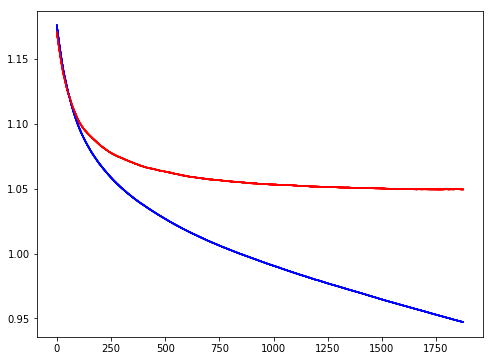

In [146]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
for i in range(0,kf_splits):
    ax.plot(perf_list[i]['training']['rmse'], color='blue')
    ax.plot(perf_list[i]['valid_1']['rmse'], color='red')

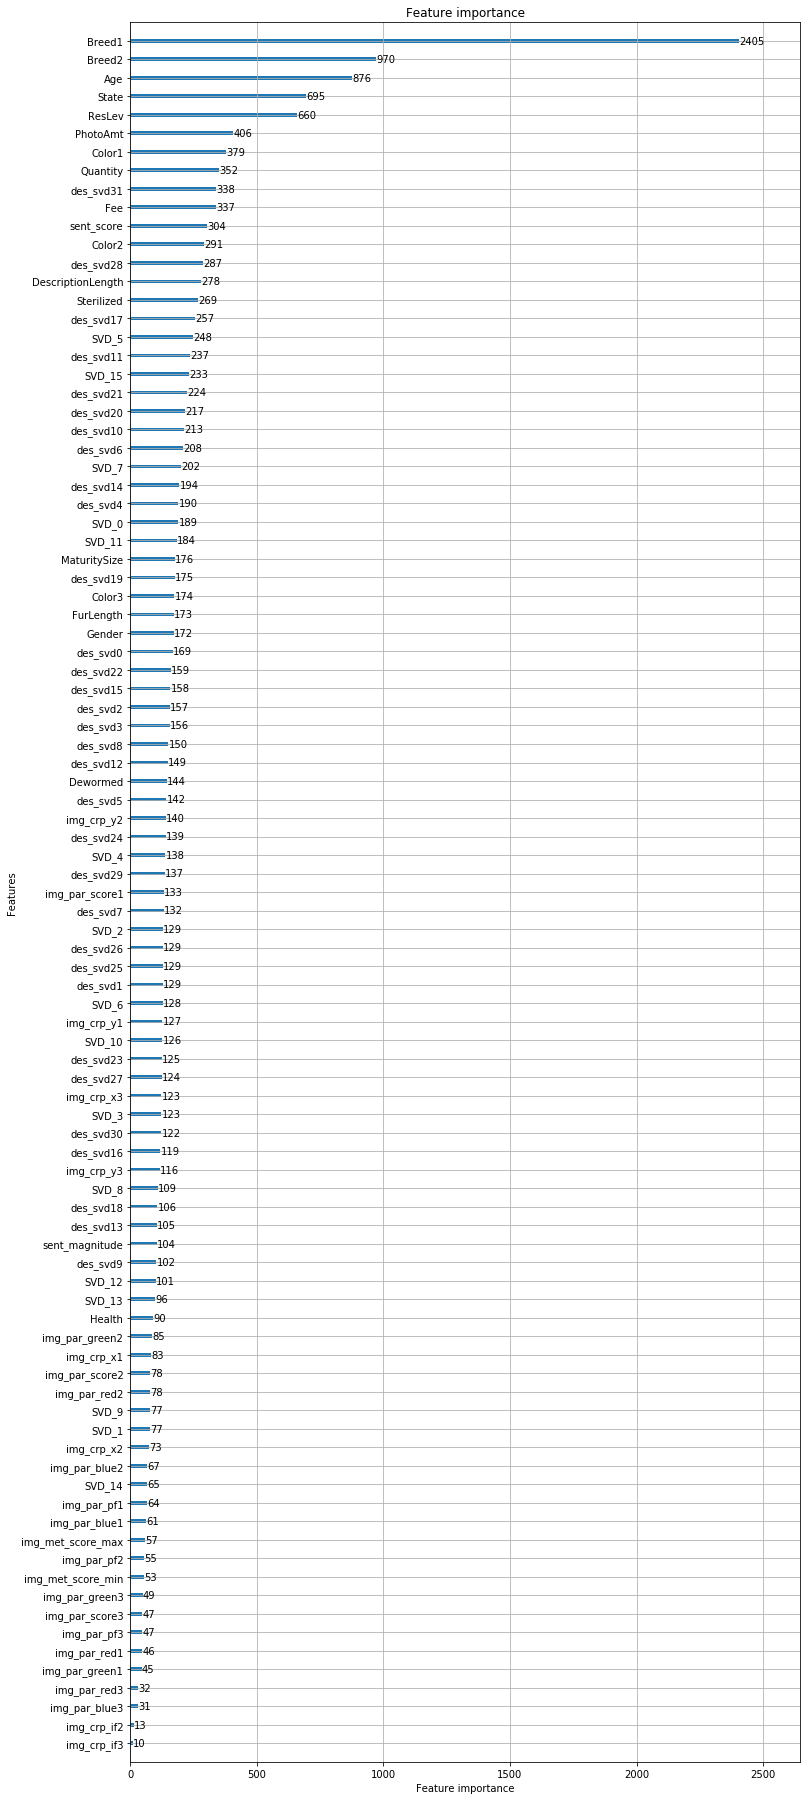

In [150]:
fig,ax = plt.subplots(1,1,figsize=(12,32))
lgb.plot_importance(lgbm, ax=ax)

In [123]:
df_qks

,best_round,qks_train,qks_valid
1,2313.0,0.463112,0.341435
2,1959.0,0.445339,0.316327
3,1771.0,0.441140,0.298184
4,2091.0,0.451788,0.346831
5,2547.0,0.481160,0.351194
6,1991.0,0.445861,0.351058
7,2054.0,0.446731,0.354013
8,2208.0,0.463931,0.341649
9,2625.0,0.485114,0.316939
10,918.0,0.370465,0.326477


In [124]:
ym=df_y.mean(axis=1)
ym.describe()

count    3948.000000
mean        2.890197
std         0.446014
min         1.536566
25%         2.544312
50%         2.873415
75%         3.215328
max         4.264391
dtype: float64

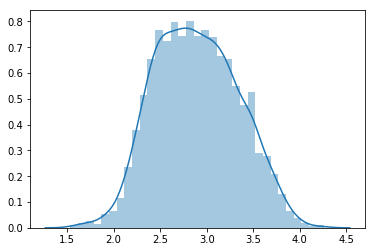

In [125]:
sns.distplot(ym)

In [126]:
df_all[df_all['AdoptionSpeed'].astype(int)>=0]['AdoptionSpeed'].value_counts()

 4    4197
 2    4037
 3    3259
 1    3090
 0     410
-1       0
Name: AdoptionSpeed, dtype: int64

Ok, I tried with a lot of different combinations of parameters but is very difficult to have a train error less than rmse=1%. But the most important thing is that with these predictions, it's impossible to fit the original distribution of Adoption Speed. For example, we have



In [127]:
sum(ym>3.5)

394

So this is the idea I think I got from the OptimizeRounder: **why simply rounding the output of LGBM**? Why not use the **additional degree of freedom** coming from a custom rounder? 

In [128]:
def distrib_err(coef,test_proba,train_label):
    test_predictions = pd.cut(test_proba, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4])
    N_CLASS=5
    freq_train=np.zeros(N_CLASS)
    freq_test=np.zeros(N_CLASS)
    delta_freq=np.zeros(N_CLASS)
    for i in range(0,N_CLASS):
        freq_train[i]=100*Counter(train_label)[i]/len(train_label)
        freq_test[i]=100*Counter(test_predictions)[i]/len(test_predictions)
        delta_freq[i]=freq_test[i]-freq_train[i]
    return np.sum(delta_freq**2)

In [129]:
initial_coef = [2.0, 2.5, 3.0, 3.5]
distrib_err_partial = partial(distrib_err, test_proba=ym, train_label=y)
final_coef = sp.optimize.minimize(distrib_err_partial, initial_coef, method='nelder-mead')
final_coef

 final_simplex: (array([[2.14830634, 2.53077351, 2.87906697, 3.17380915],
       [2.14829708, 2.53072093, 2.87905191, 3.17376315],
       [2.14839015, 2.53072697, 2.87905878, 3.1737732 ],
       [2.14831717, 2.53069831, 2.87904227, 3.17380182],
       [2.14831184, 2.53075498, 2.87909433, 3.17381261]]), array([0.40584788, 0.40584788, 0.40584788, 0.40584788, 0.40584788]))
           fun: 0.405847876562174
       message: 'Optimization terminated successfully.'
          nfev: 167
           nit: 89
        status: 0
       success: True
             x: array([2.14830634, 2.53077351, 2.87906697, 3.17380915])

Here is a function to apply a vector of custom limits:

In [130]:
def apply_lim(y_calc,limits):
    y_round=np.zeros(len(y_calc))
    for i,yc in enumerate(y_calc):
        if (yc<=limits[0]):
            y_round[i]=0
        if ((yc>limits[0])&(yc<=limits[1])): 
            y_round[i]=1
        if ((yc>limits[1])&(yc<=limits[2])): 
            y_round[i]=2
        if ((yc>limits[2])&(yc<=limits[3])):
            y_round[i]=3
        if (yc>limits[3]):
            y_round[i]=4
    return y_round

Let's try to map it into the original one:

In [131]:
y_test_pred_r = apply_lim(ym,final_coef['x'])

# Final Submission

In [132]:
y_pred = y_test_pred_r.astype('int')

In [133]:
subm=pd.DataFrame({'PetID': dftest_ids,'AdoptionSpeed': y_pred})
subm.head()

,PetID,AdoptionSpeed
14993,378fcc4fc,1
14994,73c10e136,3
14995,72000c4c5,3
14996,e147a4b9f,2
14997,43fbba852,4


In [134]:
subm['AdoptionSpeed'].value_counts()

4    1096
2    1057
3     856
1     809
0     130
Name: AdoptionSpeed, dtype: int64

In [135]:
subm.to_csv('submission.csv', index=False)